In [139]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Set a consistent plotting style
plt.rcParams["figure.dpi"] = 120

# Create results folder (relative)
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

In [140]:
# Load raw data (relative path)
file_path = Path("data/raw/use_all_btu.csv")
data = pd.read_csv(file_path)
print("First 5 rows of the dataset:")
display(data.head())

# Basic info
print("\nData info:")
data.info()

# Check missingness
print("\nMissing values per column (sample):")
print(data.isnull().sum().sort_values(ascending=False).head(15))

First 5 rows of the dataset:


,Data_Status,State,MSN,1960,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,2022F,AK,ABICB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.0,-2.0,-3.0,-3.0,-2.0,-14.0,-10.0,-7.0,-8.0,-6.0
1,2022F,AK,ARICB,312.0,555.0,489.0,589.0,791.0,878.0,1646.0,...,12763.0,12335.0,12450.0,12365.0,13561.0,4804.0,11973.0,12391.0,13425.0,12981.0
2,2022F,AK,ARTCB,312.0,555.0,489.0,589.0,791.0,878.0,1646.0,...,12763.0,12335.0,12450.0,12365.0,13561.0,4804.0,11973.0,12391.0,13425.0,12981.0
3,2022F,AK,ARTXB,312.0,555.0,489.0,589.0,791.0,878.0,1646.0,...,12763.0,12335.0,12450.0,12365.0,13561.0,4804.0,11973.0,12391.0,13425.0,12981.0
4,2022F,AK,AVACB,5209.0,6441.0,5202.0,3273.0,2319.0,1478.0,1086.0,...,701.0,658.0,1308.0,1240.0,1239.0,1264.0,1245.0,915.0,1037.0,1073.0



Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14773 entries, 0 to 14772
Data columns (total 66 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Data_Status  14773 non-null  object 
 1   State        14773 non-null  object 
 2   MSN          14773 non-null  object 
 3   1960         10509 non-null  float64
 4   1961         10509 non-null  float64
 5   1962         10509 non-null  float64
 6   1963         10509 non-null  float64
 7   1964         10509 non-null  float64
 8   1965         10509 non-null  float64
 9   1966         10509 non-null  float64
 10  1967         10509 non-null  float64
 11  1968         10509 non-null  float64
 12  1969         10509 non-null  float64
 13  1970         10509 non-null  float64
 14  1971         10509 non-null  float64
 15  1972         10509 non-null  float64
 16  1973         10509 non-null  float64
 17  1974         10509 non-null  float64
 18  1975         10509 non-null  float

# Observations from the Data

## Structure:

- The dataset has 14,773 rows and 66 columns.
- The columns Data_Status, State, and MSN are categorical, while the rest are numeric years (1960–2022).

## Missing Data:

- The columns for earlier years (1960–1969) have significant missing values (4264 out of 14,773 rows).
- Recent years (2018–2022) have no missing values.

## Potentially Useful Columns

- Data_Status: Indicates the status of the data (final forecast).
- State: State-wise energy consumption data.
- MSN: Codes for energy types or activities (must decode using msn_codes_and_descriptions.xlsx).

## Time-Series Structure:

- Data is structured as a time series, with rows representing State and MSN, and columns being years (1960–2022).

In [141]:
# Melt the raw data into long format (years -> rows)
data_long = pd.melt(
    data,
    id_vars=['Data_Status', 'State', 'MSN'],
    var_name='Year',
    value_name='Energy_Consumption'
)

# Convert Year to int if possible
# Some notebooks may have stray strings in header; coerce to numeric then drop NaNs later
data_long['Year'] = pd.to_numeric(data_long['Year'], errors='coerce').astype('Int64')

print("\nLong-form sample:")
display(data_long.head())


Long-form sample:


,Data_Status,State,MSN,Year,Energy_Consumption
0,2022F,AK,ABICB,1960,0.0
1,2022F,AK,ARICB,1960,312.0
2,2022F,AK,ARTCB,1960,312.0
3,2022F,AK,ARTXB,1960,312.0
4,2022F,AK,AVACB,1960,5209.0


In [142]:
# Load and clean MSN descriptions (sheet: 'MSN descriptions')
msn_codes_path = Path("docs/msn_codes_and_descriptions.xlsx")
msn_descriptions_df = pd.read_excel(msn_codes_path, sheet_name='MSN descriptions')

# Keep only the important columns and drop rows with missing keys
msn_cleaned_df = msn_descriptions_df[['MSN', 'Description', 'Unit']].dropna().reset_index(drop=True)
print("\nMSN description sample:")
display(msn_cleaned_df.head())


MSN description sample:


,MSN,Description,Unit
0,ABICB,Aviation gasoline blending components consumed...,Billion Btu
1,ABICP,Aviation gasoline blending components consumed...,Thousand barrels
2,ARICB,Asphalt and road oil consumed by the industria...,Billion Btu
3,ARICD,Asphalt and road oil price in the industrial s...,Dollars per million Btu
4,ARICP,Asphalt and road oil consumed by the industria...,Thousand barrels


In [143]:
# Merge dataset with msn descriptions (one canonical merge, saved to processed)
data_raw = Path("data/raw/use_all_btu.csv")
data_processed = Path("data/processed/use_all_btu_with_descriptions.csv")
use_all_btu_df = pd.read_csv(data_raw)

merged_df = pd.merge(use_all_btu_df, msn_cleaned_df, on="MSN", how="left")
merged_df.to_csv(data_processed, index=False)


In [144]:
# Filter for nuclear-related MSNs and reshape to long format once (canonical)
nuclear_data = merged_df[merged_df['Description'].str.contains('nuclear', case=False, na=False)].copy()
display(nuclear_data.head())

# Melt nuclear table (years -> rows) and clean types
nuclear_long = pd.melt(
    nuclear_data,
    id_vars=['Data_Status', 'State', 'MSN', 'Description', 'Unit'],
    var_name='Year',
    value_name='Energy_Consumption'
)

# Convert Year and Energy_Consumption to numeric and drop invalid rows
nuclear_long['Year'] = pd.to_numeric(nuclear_long['Year'], errors='coerce')
nuclear_long['Energy_Consumption'] = pd.to_numeric(nuclear_long['Energy_Consumption'], errors='coerce')
nuclear_long = nuclear_long.dropna(subset=['Year', 'Energy_Consumption']).copy()
nuclear_long['Year'] = nuclear_long['Year'].astype(int)

print("\nNuclear long sample (clean):")
display(nuclear_long.head())

,Data_Status,State,MSN,1960,1961,1962,1963,1964,1965,1966,...,2015,2016,2017,2018,2019,2020,2021,2022,Description,Unit
160,2022F,AK,NUCAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nuclear generating units capacity factor,Percent
161,2022F,AK,NUEGB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nuclear energy consumed for electricity genera...,Billion Btu
162,2022F,AK,NUETB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nuclear energy consumed for electricity genera...,Billion Btu
163,2022F,AK,NUGBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nuclear generating units net summer capacity i...,Thousand kilowatts
444,2022F,AL,NUCAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,94.5,89.8,96.2,87.7,90.8,89.4,96.4,88.6,Nuclear generating units capacity factor,Percent



Nuclear long sample (clean):


,Data_Status,State,MSN,Description,Unit,Year,Energy_Consumption
1,2022F,AK,NUEGB,Nuclear energy consumed for electricity genera...,Billion Btu,1960,0.0
2,2022F,AK,NUETB,Nuclear energy consumed for electricity genera...,Billion Btu,1960,0.0
5,2022F,AL,NUEGB,Nuclear energy consumed for electricity genera...,Billion Btu,1960,0.0
6,2022F,AL,NUETB,Nuclear energy consumed for electricity genera...,Billion Btu,1960,0.0
9,2022F,AR,NUEGB,Nuclear energy consumed for electricity genera...,Billion Btu,1960,0.0


NUETB - total nuclear energy used

NUEGB - nuclear fuel consumed to generate that electricity

NUGBP - electricity generated

NUCAS - capacity available (how much could be produced)

In [145]:
# Convert units once: Billion BTU -> GWh (industry-friendly)
# 1 Billion BTU ≈ 293.071 MWh -> /1000 -> GWh
BTU_TO_MWH = 293.071
if 'Energy_GWh' not in nuclear_long.columns:
    nuclear_long['Energy_GWh'] = nuclear_long['Energy_Consumption'].astype(float) * BTU_TO_MWH / 1000

# Quick sanity check
print("Energy_GWh sample stats:")
print(nuclear_long['Energy_GWh'].describe())

Energy_GWh sample stats:
count    8.112000e+03
mean     4.545883e+04
std      2.183186e+05
min     -3.836299e+02
25%      0.000000e+00
50%      2.652293e+01
75%      3.080367e+04
max      2.478967e+06
Name: Energy_GWh, dtype: float64


The dataset is highly skewed: most states produce very little nuclear energy, while a few states and the national aggregates dominate the generation totals.

- Most rows represent small or zero nuclear generation. Many states don’t use nuclear power.

- A few rows represent massive amounts of GWh, driven by large nuclear states or U.S. totals.

- The large standard deviation confirms high variability in nuclear production across states and years.

- Negative values exist due to energy accounting adjustments, not actual negative power generation.

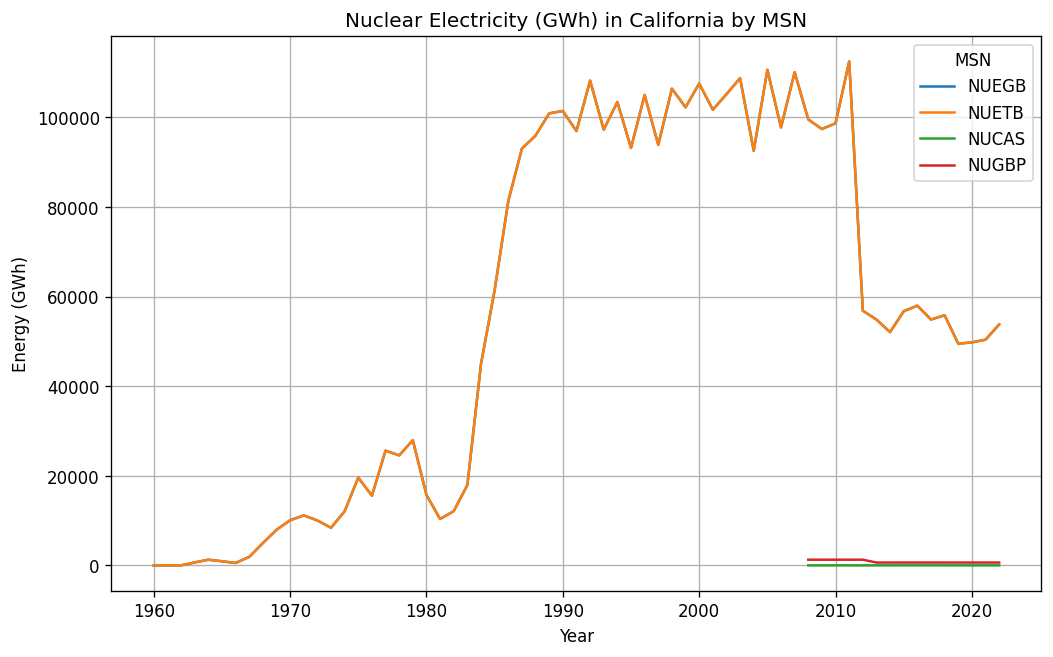

In [146]:
# Quick EDA plots California
results_path = results_dir

state_data = nuclear_long[nuclear_long['State'] == 'CA']
plt.figure(figsize=(10, 6))
for msn in state_data['MSN'].unique():
    subset = state_data[state_data['MSN'] == msn].sort_values('Year')
    plt.plot(subset['Year'], subset['Energy_GWh'], label=msn)
plt.title("Nuclear Electricity (GWh) in California by MSN")
plt.xlabel("Year")
plt.ylabel("Energy (GWh)")
plt.legend(title="MSN")
plt.grid()
plt.savefig(results_path / "nuclear_california_gwh_by_msn.png", dpi=300, bbox_inches="tight")
plt.show()

From 1960 through the mid-1980s, nuclear energy consumption increased rapidly.

The plateau around 350,000+ Billion BTUs indicates a stable period of nuclear power usage at full capacity.

Dramatic collapse around 2012. The shutdown of the San Onofre Nuclear Generating Station (SONGS) in 2012.

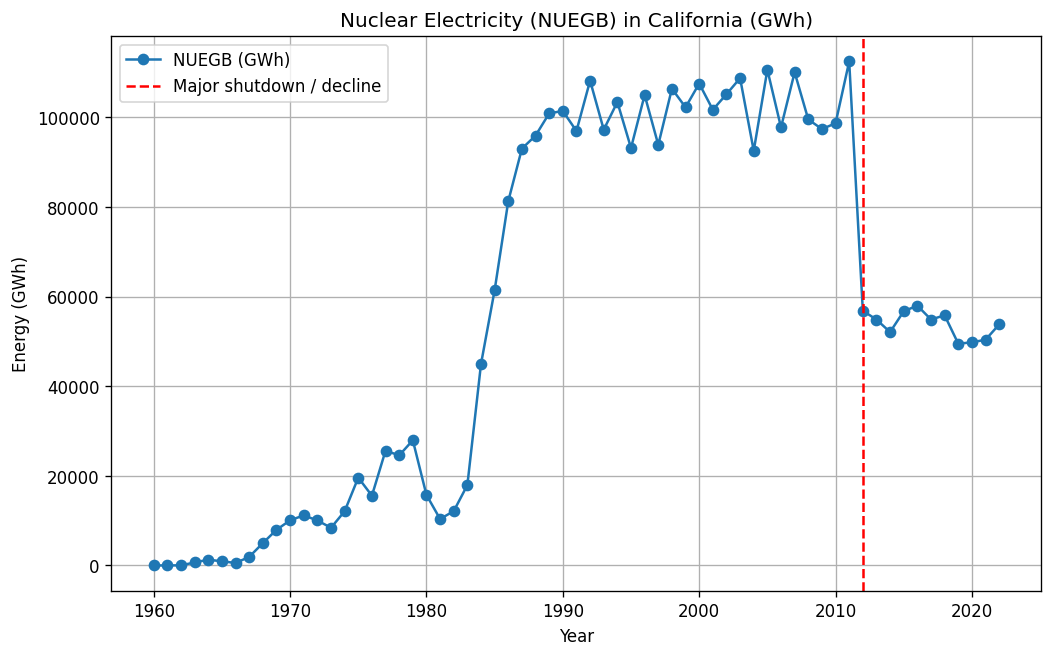

In [147]:
# Focus on NUEGB (nuclear fuel consumed to generate electricity) and CA
nuegb_data = nuclear_long[
    (nuclear_long['State'].str.upper() == "CA") &
    (nuclear_long['MSN'] == "NUEGB")
].sort_values("Year")

plt.figure(figsize=(10, 6))
plt.plot(nuegb_data["Year"], nuegb_data["Energy_GWh"], marker="o", label="NUEGB (GWh)")
plt.axvline(x=2012, color="red", linestyle="--", label="Major shutdown / decline")
plt.title("Nuclear Electricity (NUEGB) in California (GWh)")
plt.xlabel("Year")
plt.ylabel("Energy (GWh)")
plt.legend()
plt.grid()
plt.savefig(results_path / "nuegb_california_gwh.png", dpi=300, bbox_inches="tight")
plt.show()


The shutdown of the San Onofre Nuclear Generating Station (SONGS) in 2012.

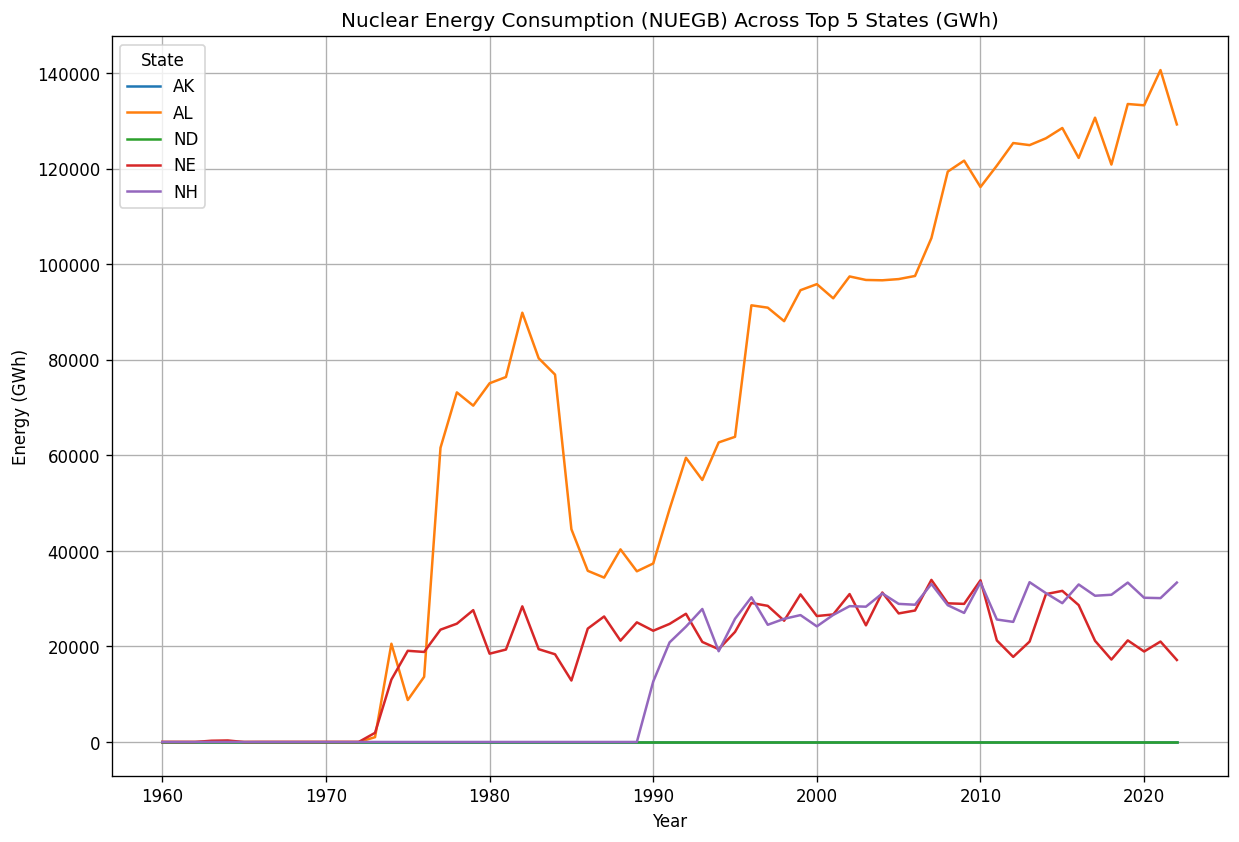

In [ ]:
# Focus on NUEGB across all states 
nuegb_all_states = nuclear_long[nuclear_long["MSN"] == "NUEGB"]

# Find the top 5 states with the most available yearly data 
top_states = nuegb_all_states["State"].value_counts().head(5).index

plt.figure(figsize=(12, 8))

for state in top_states:
    state_data = (
        nuegb_all_states[nuegb_all_states["State"] == state]
        .sort_values("Year")
    )
    plt.plot(state_data["Year"], state_data["Energy_GWh"], label=state)

plt.title("Nuclear Energy Consumption (NUEGB) Across Top 5 States (GWh)")
plt.xlabel("Year")
plt.ylabel("Energy (GWh)")
plt.legend(title="State")
plt.grid()
plt.show()

Alabama has by far the most nuclear fuel consumption among these states. Hosts some of the largest nuclear facilities in the U.S. like Browns Ferry Nuclear Plant.

New Hampshire jumps into the chart around 1990, matching the commissioning year of the Seabrook nuclear plant.

North Dakota and Alaska show essentially zero. They show up on the chart only because they appear in the top 5 due to record count (not consumption volume).

In [149]:
# Top states by total NUEGB generation (exclude national 'US' row)
state_totals_gwh = (
    nuclear_long[(nuclear_long['MSN'] == 'NUEGB') & (nuclear_long['State'] != 'US')]
    .groupby('State')['Energy_GWh']
    .sum()
    .sort_values(ascending=False)
)

print("Top states for nuclear electricity generation (GWh):")
display(state_totals_gwh.head())


Top states for nuclear electricity generation (GWh):


State
IL    1.090469e+07
PA    8.573893e+06
SC    6.399538e+06
NY    4.811871e+06
NC    4.488041e+06
Name: Energy_GWh, dtype: float64

Nuclear power generation is highly concentrated geographically. Just five states account for the majority of all nuclear electricity produced in the U.S. This highlights how nuclear infrastructure is regionally clustered rather than evenly distributed.

Illinois alone generated over 1 million GWh of nuclear electricity across the dataset — more than any other state

Top states to plot: ['IL', 'PA', 'SC', 'NY', 'NC']


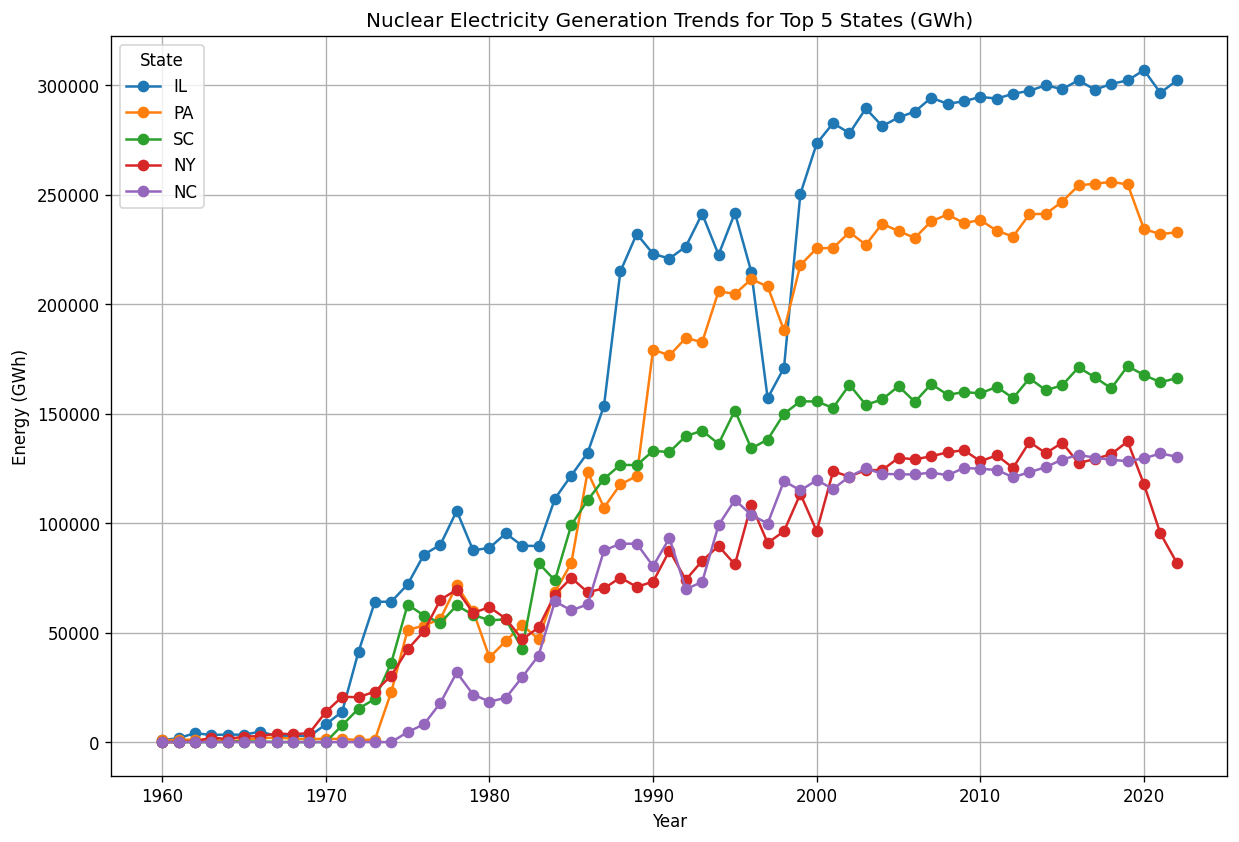

In [160]:
# Plot top 5 states trends by total GWh
top_states = state_totals_gwh.nlargest(5).index.tolist()
print("Top states to plot:", top_states)

plt.figure(figsize=(12, 8))
for state in top_states:
    sdata = nuclear_long[(nuclear_long['State'] == state) & (nuclear_long['MSN'] == 'NUEGB')].sort_values('Year')
    plt.plot(sdata['Year'], sdata['Energy_GWh'], marker='o', label=state)
plt.title("Nuclear Electricity Generation Trends for Top 5 States (GWh)")
plt.xlabel("Year")
plt.ylabel("Energy (GWh)")
plt.legend(title="State")
plt.grid(True)
plt.savefig(results_path / "nuegb_top5_states_gwh.png", dpi=300, bbox_inches="tight")
plt.show()

Annual nuclear electricity generation (NUEGB) for the five states with the highest total output across the dataset. 

Illinois produces the most nuclear electricity and has maintained high output since the late 1980s. 

Pennsylvania and South Carolina are also major contributors. 

New York’s decline in the 2010s corresponds to plant retirements, illustrating how retirements materially reduce state-level generation.

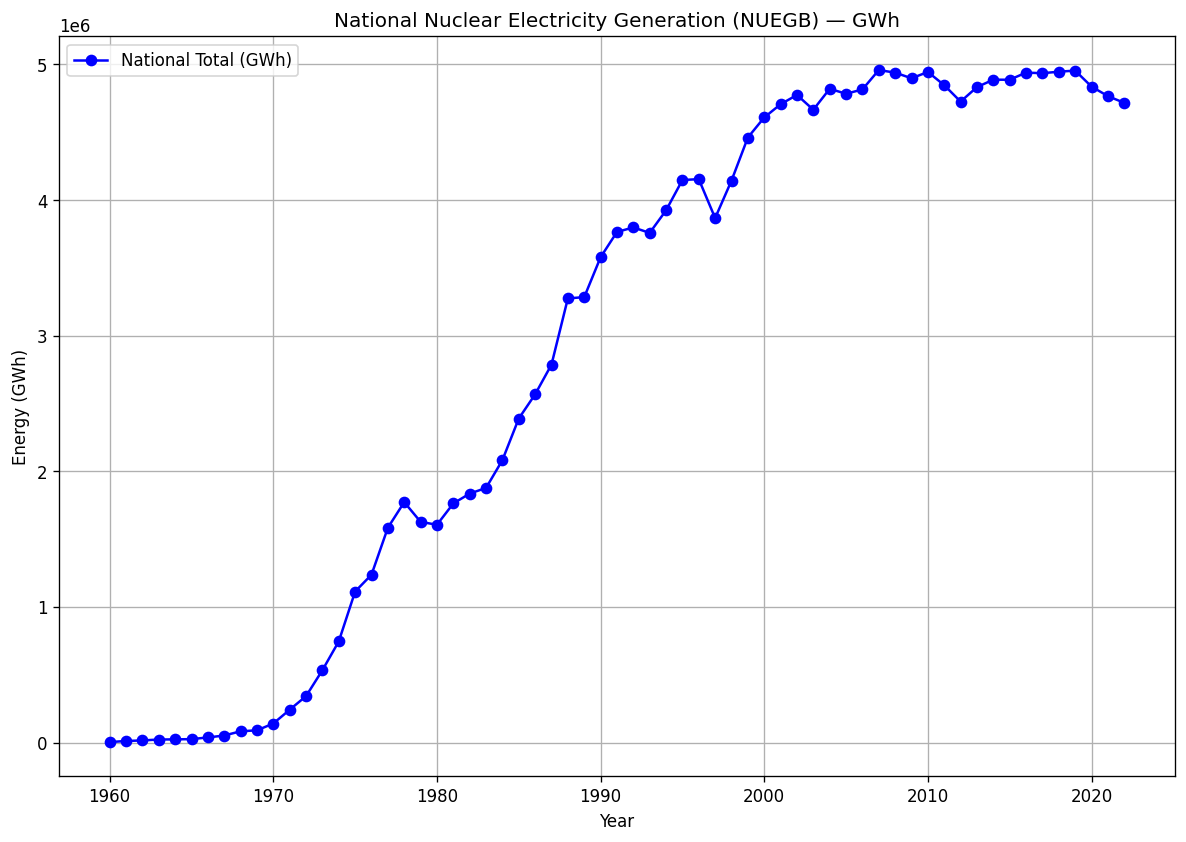

In [151]:
# National total time series for NUEGB (GWh)
national_trends = (
    nuclear_long[nuclear_long['MSN'] == 'NUEGB']
    .groupby('Year')['Energy_GWh']
    .sum()
)
plt.figure(figsize=(12, 8))
plt.plot(national_trends.index, national_trends.values, marker='o', color='blue', label='National Total (GWh)')
plt.title("National Nuclear Electricity Generation (NUEGB) — GWh")
plt.xlabel("Year")
plt.ylabel("Energy (GWh)")
plt.grid(True)
plt.legend()
plt.savefig(results_path / "nuegb_national_gwh.png", dpi=300, bbox_inches="tight")
plt.show()

The trend shows the U.S. nuclear fleet going through three phases: rapid expansion, steady plateau, and gradual decline. 

After 1990, generation stays flat because we stopped building new reactors, not because performance deteriorated. In fact, capacity factors improved, but retirements in the 2010s start pulling the curve down.

In [162]:
# Total consumption by state for NUEGB, excluding the US aggregate row
state_totals = (
    nuclear_long[
        (nuclear_long['MSN'] == 'NUEGB') &
        (nuclear_long['State'] != 'US')        # <-- exclude national total
    ]
    .groupby('State')['Energy_Consumption']
    .sum()
    .sort_values(ascending=False)
)

print("Top states for nuclear energy consumption (excluding US):")
print(state_totals.head())


Top states for nuclear energy consumption (excluding US):
State
IL    37208343.0
PA    29255343.0
SC    21836134.0
NY    16418788.0
NC    15313836.0
Name: Energy_Consumption, dtype: float64


In [163]:

# Prepare national series (US) for forecasting starting from 1960
national_data_1960 = nuclear_long[
    (nuclear_long['State'] == 'US') &
    (nuclear_long['Year'] >= 1960) &
    (nuclear_long['MSN'] == 'NUEGB')
].sort_values('Year').copy()

# Convert index to PeriodIndex (annual) for statsmodels / pmdarima friendly behavior
national_data_1960['Year'] = national_data_1960['Year'].astype(int)
series_gwh = national_data_1960.set_index(pd.PeriodIndex(national_data_1960['Year'], freq='A'))['Energy_GWh'].astype(float)

# Train / test split (all but last 5 years)
train_series = series_gwh.iloc[:-5]
test_series = series_gwh.iloc[-5:]

print("Train period:", train_series.index.min(), "-", train_series.index.max())
print("Test period:", test_series.index.min(), "-", test_series.index.max())

Train period: 1960 - 2017
Test period: 2018 - 2022


C:\Users\mathe\AppData\Local\Temp\ipykernel_18396\1911811345.py:10: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  series_gwh = national_data_1960.set_index(pd.PeriodIndex(national_data_1960['Year'], freq='A'))['Energy_GWh'].astype(float)


MAE (GWh): 71,547.11
RMSE (GWh): 92,841.26

Forecast vs Actual (GWh):
        Actual_GWh  Forecast_GWh
Year                            
2018  2.472953e+06  2.476192e+06
2019  2.476993e+06  2.484875e+06
2020  2.418151e+06  2.493470e+06
2021  2.382935e+06  2.501980e+06
2022  2.358155e+06  2.510405e+06


C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


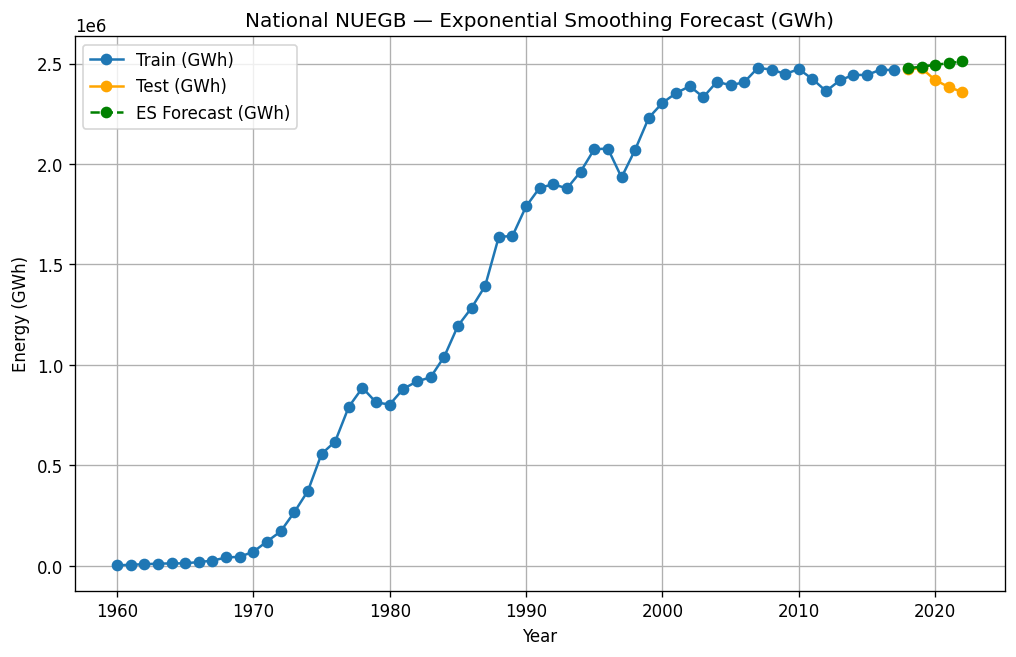

In [154]:
# Exponential Smoothing (damped additive trend) - fitted on the 1-D PeriodIndex series
es_model = ExponentialSmoothing(train_series, trend="add", seasonal=None, damped_trend=True)

# Fit model – no maxiter or remove_bias allowed in current statsmodels version
es_fit = es_model.fit(optimized=True)

# Forecast and align index
es_forecast = es_fit.forecast(steps=len(test_series))
es_forecast.index = test_series.index  # align with actual test data

# Metrics
mae = mean_absolute_error(test_series.values, es_forecast.values)
rmse = math.sqrt(mean_squared_error(test_series.values, es_forecast.values))

print(f"MAE (GWh): {mae:,.2f}")
print(f"RMSE (GWh): {rmse:,.2f}\n")

# Display actual vs forecast for transparency
print("Forecast vs Actual (GWh):")
print(pd.concat(
    [test_series.rename("Actual_GWh"), es_forecast.rename("Forecast_GWh")],
    axis=1
))

# Plot train/test/forecast
plt.figure(figsize=(10,6))
plt.plot(train_series.index.to_timestamp(), train_series.values, label='Train (GWh)', marker='o')
plt.plot(test_series.index.to_timestamp(), test_series.values, label='Test (GWh)', marker='o', color='orange')
plt.plot(es_forecast.index.to_timestamp(), es_forecast.values, label='ES Forecast (GWh)', marker='o', linestyle='--', color='green')
plt.title("National NUEGB — Exponential Smoothing Forecast (GWh)")
plt.xlabel("Year")
plt.ylabel("Energy (GWh)")
plt.legend(); plt.grid(True)
plt.savefig(results_path / "nuegb_es_forecast_gwh.png", dpi=300, bbox_inches="tight")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1439.811, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1436.424, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1434.494, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1434.431, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1453.187, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1436.560, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1436.711, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1438.593, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1444.611, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.118 seconds
Auto ARIMA MAE (GWh): 157,807.83
Auto ARIMA RMSE (GWh): 189,674.38
Auto ARIMA MAPE (%): 6.60%


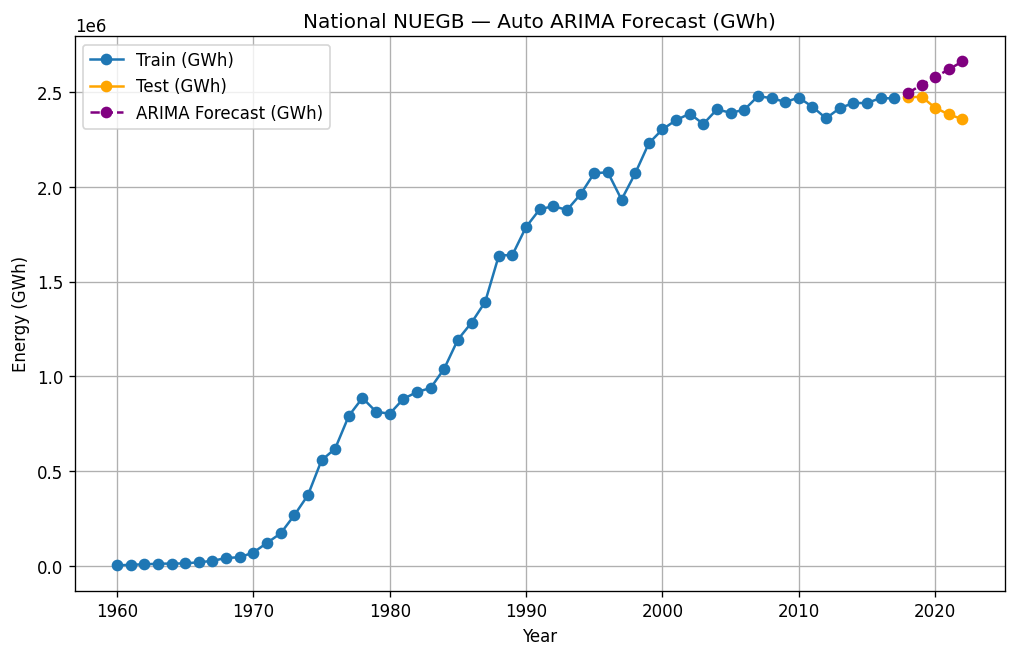

In [155]:
# Auto ARIMA on the 1-D series (train)
auto_arima_model = pm.auto_arima(
    train_series,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)

# Forecast with auto_arima and compute metrics
arima_forecast = pd.Series(auto_arima_model.predict(n_periods=len(test_series)), index=test_series.index)
arima_mae = mean_absolute_error(test_series.values, arima_forecast.values)
arima_rmse = math.sqrt(mean_squared_error(test_series.values, arima_forecast.values))
arima_mape = np.mean(np.abs((test_series.values - arima_forecast.values) / test_series.values)) * 100

print(f"Auto ARIMA MAE (GWh): {arima_mae:,.2f}")
print(f"Auto ARIMA RMSE (GWh): {arima_rmse:,.2f}")
print(f"Auto ARIMA MAPE (%): {arima_mape:.2f}%")

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_series.index.to_timestamp(), train_series.values, label='Train (GWh)', marker='o')
plt.plot(test_series.index.to_timestamp(), test_series.values, label='Test (GWh)', marker='o', color='orange')
plt.plot(arima_forecast.index.to_timestamp(), arima_forecast.values, label='ARIMA Forecast (GWh)', marker='o', linestyle='--', color='purple')
plt.title("National NUEGB — Auto ARIMA Forecast (GWh)")
plt.xlabel("Year"); plt.ylabel("Energy (GWh)")
plt.legend(); plt.grid(True)
plt.savefig(results_path / "nuegb_auto_arima_forecast_gwh.png", dpi=300, bbox_inches="tight")
plt.show()


In [156]:
# Prepare supervised learning features using lagged Energy_GWh (not Energy_Consumption)
def create_lagged_features_gwh(series, lags=3):
    df = pd.DataFrame({'Energy_GWh': series})
    for lag in range(1, lags + 1):
        df[f'Lag_{lag}'] = df['Energy_GWh'].shift(lag)
    df = df.dropna()
    return df

# Use the same national series (annual, PeriodIndex)
ml_df = create_lagged_features_gwh(series_gwh, lags=3)

# Align train/test split (use last 5 rows as test)
X = ml_df.drop(columns=['Energy_GWh'])
y = ml_df['Energy_GWh']
X_train = X.iloc[:-5].values
y_train = y.iloc[:-5].values
X_test = X.iloc[-5:].values
y_test = y.iloc[-5:].values

print("ML training rows:", X_train.shape[0], "Testing rows:", X_test.shape[0])

ML training rows: 55 Testing rows: 5


XGBoost MAE (GWh): 25,335.24
XGBoost RMSE (GWh): 33,789.88
XGBoost MAPE (%): 1.05%


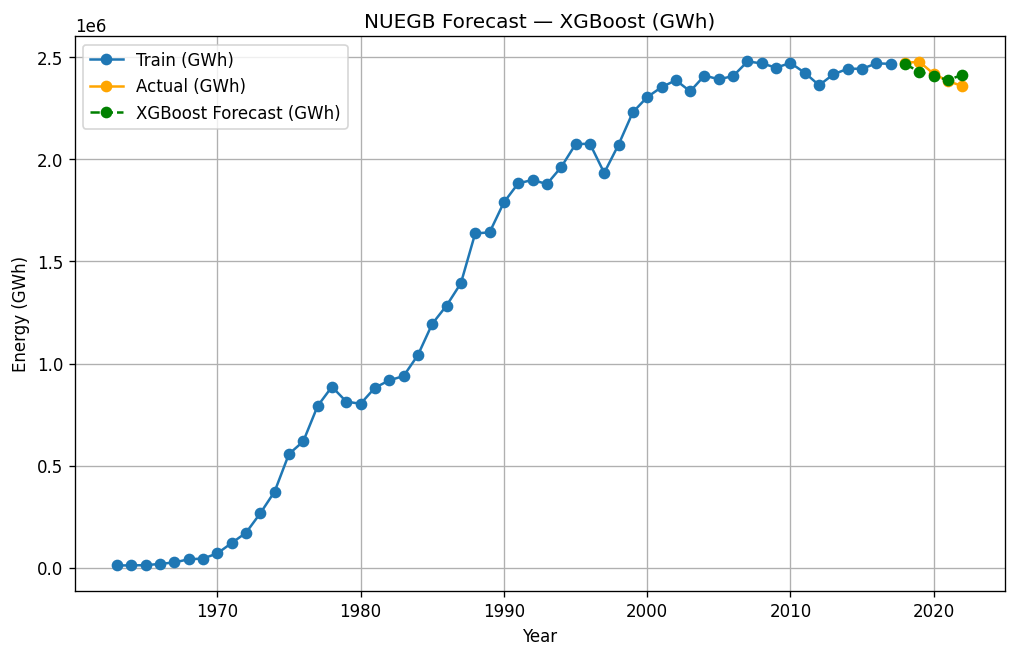

In [157]:
# XGBoost model (trained on GWh lag features)
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = math.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100

print(f"XGBoost MAE (GWh): {xgb_mae:,.2f}")
print(f"XGBoost RMSE (GWh): {xgb_rmse:,.2f}")
print(f"XGBoost MAPE (%): {xgb_mape:.2f}%")

# Plot
years_test = ml_df.index[-5:].to_timestamp()
plt.figure(figsize=(10,6))
plt.plot(ml_df.index[:-5].to_timestamp(), y.iloc[:-5], label='Train (GWh)', marker='o')
plt.plot(years_test, y_test, label='Actual (GWh)', marker='o', color='orange')
plt.plot(years_test, xgb_pred, label='XGBoost Forecast (GWh)', marker='o', linestyle='--', color='green')
plt.title("NUEGB Forecast — XGBoost (GWh)")
plt.xlabel("Year"); plt.ylabel("Energy (GWh)")
plt.legend(); plt.grid(True)
plt.savefig(results_path / "nuegb_xgb_forecast_gwh.png", dpi=300, bbox_inches="tight")
plt.show()



Random Forest MAE (GWh): 30,741.61
Random Forest RMSE (GWh): 35,368.62
Random Forest MAPE (%): 1.27%


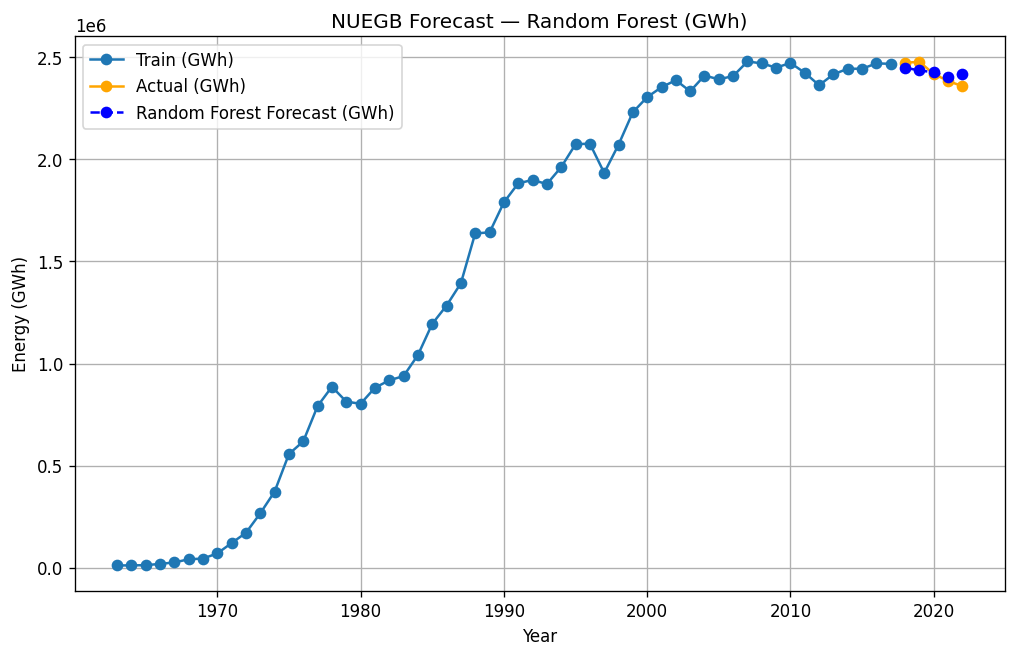

In [158]:
# Random Forest model (same inputs)
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = math.sqrt(mean_squared_error(y_test, rf_pred))
rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100

print(f"Random Forest MAE (GWh): {rf_mae:,.2f}")
print(f"Random Forest RMSE (GWh): {rf_rmse:,.2f}")
print(f"Random Forest MAPE (%): {rf_mape:.2f}%")

# Plot
plt.figure(figsize=(10,6))
plt.plot(ml_df.index[:-5].to_timestamp(), y.iloc[:-5], label='Train (GWh)', marker='o')
plt.plot(years_test, y_test, label='Actual (GWh)', marker='o', color='orange')
plt.plot(years_test, rf_pred, label='Random Forest Forecast (GWh)', marker='o', linestyle='--', color='blue')
plt.title("NUEGB Forecast — Random Forest (GWh)")
plt.xlabel("Year"); plt.ylabel("Energy (GWh)")
plt.legend(); plt.grid(True)
plt.savefig(results_path / "nuegb_rf_forecast_gwh.png", dpi=300, bbox_inches="tight")
plt.show()


In [164]:
es_mae  = mean_absolute_error(test_series.values, es_forecast.values)
es_rmse = math.sqrt(mean_squared_error(test_series.values, es_forecast.values))
es_mape = np.mean(np.abs((test_series.values - es_forecast.values) / test_series.values)) * 100

def safe_get(name):
    return globals().get(name, np.nan)

summary = pd.DataFrame({
    'model': ['ExponentialSmoothing', 'AutoARIMA', 'XGBoost', 'RandomForest'],
    'MAE_GWh':  [safe_get('es_mae'),   safe_get('arima_mae'),   safe_get('xgb_mae'),   safe_get('rf_mae')],
    'RMSE_GWh': [safe_get('es_rmse'),  safe_get('arima_rmse'),  safe_get('xgb_rmse'),  safe_get('rf_rmse')],
    'MAPE_pct': [safe_get('es_mape'),  safe_get('arima_mape'),  safe_get('xgb_mape'),  safe_get('rf_mape')]
})

print("\nModel comparison (GWh):")
display(summary)

out_csv = results_path / "model_comparison_summary_gwh.csv"
summary.to_csv(out_csv, index=False)
print(f"\nSaved model summary to: {out_csv.resolve()}")



Model comparison (GWh):


,model,MAE_GWh,RMSE_GWh,MAPE_pct
0,ExponentialSmoothing,71547.110128,92841.255471,3.003199
1,AutoARIMA,157807.827042,189674.378138,6.602834
2,XGBoost,25335.235438,33789.884310,1.049345
3,RandomForest,30741.607519,35368.615038,1.273364



Saved model summary to: C:\Code\Energy-Consumption-Forecast\results\model_comparison_summary_gwh.csv
